## Week 18: Data visualization sandbox
(adapted from jhemann's Jupyter notebook)

We'll be doing some hands-on exploration of Python data viz capabilities via a fun mini-project on sunspots. We'll also be making use of Pandas dataframes!

In [5]:
## a quick dataframes refresher:

import random

names = ["Kelly","Anum","Sophia","Angelica","Lizbeth", "Helena"]
dessert = ["pie","cannoli","cookie","icecream","cupcake", "creampuff"]
quantity = [10*random.randint(10,30) for _ in range(10)]

def generate_random_person(names, surnames, salaries):
    return {"name":random.sample(names,1)[0],
            "surname":random.sample(dessert,1)[0],
            "salary":random.sample(quantity,1)[0]}

def generate_people(k):
    return [generate_random_person(names, dessert, quantity) for _ in range(k)]

Inspect the cell above -- what's happening? What do the generate_random_person() and generate_people() functions do?

How would you generate a dataframe with 50 data points using both of these functions (hint: you might be interested in the documentation for the pd.Dataframe() function)? Jot down your thoughts and code below: 

In [4]:
## code for generating a dataframe of 50 random names, desserts, and quantities:




Now, we can think about applying our knowledge of dataframes to some sunspot data! As you're working, think about how you might also use these techniques for visualizing our genomic data...

First things first, let's load the sunspots data, which is easy to find (e.g. [from NOAA](ftp://ftp.ngdc.noaa.gov/STP/SOLAR_DATA/SUNSPOT_NUMBERS/)) and conveniently included in a popular Python package for doing statistical work... 

In [6]:
import statsmodels.api as sm
import pandas as pd
data_loader = sm.datasets.sunspots.load_pandas()
df = data_loader.data

`df` is shorthand for "dataframe", which we can think of as an Excel-like table of values. Dataframes have various methods that can be called to easily learn about the data contained in them, and we'll step through calling some of these methods. Below, we see that we have 309 pairs of (year, activity) to examine... 

In [2]:
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309 entries, 0 to 308
Data columns:
YEAR           309  non-null values
SUNACTIVITY    309  non-null values
dtypes: float64(2)

We can quickly inspect the first and last handful of values to get an idea of what the data look like...

In [3]:
df.head()

,YEAR,SUNACTIVITY
0,1700,5
1,1701,11
2,1702,16
3,1703,23
4,1704,36


In [4]:
df.tail()

,YEAR,SUNACTIVITY
304,2004,40.4
305,2005,29.8
306,2006,15.2
307,2007,7.5
308,2008,2.9


OK, so the time series of annual values starts in 1700 and goes through 2008. Notice that we have fractional numbers in the more recent observations. This got me wondering when these fractional values started appearing...

In [5]:
fractional_nums = df['SUNACTIVITY'].apply(lambda x: x % 1) #Take the modulo of each value with 1 to get the fractional part
fractional_nums[fractional_nums > 0].head()

49    0.9
50    0.4
51    0.7
52    0.8
53    0.7
Name: SUNACTIVITY

The first fractional value occurs in 1749. I looked into this a bit and (re)learned a few things:

* Galileo first documented sunspots in the early 1600s, using his newly invented _telescope_
* Reliable sunspot observations begin in about 1700
* The fractional numbers are probably associated with data coming out of Zurich, Switzerland in 1749 onward
* The methodology for tallying sunspot counts has evolved, most notably in 1848 with the introduction of the [Wolf number](http://en.wikipedia.org/wiki/Wolf_number) (which  is not simply an integer count)
* There seems to be a [fair bit of debate](http://www.leif.org/research/IAUS286-Mendoza-Svalgaard.pdf) about how accurate the existing data are

With some context in hand regarding the data generating process, let's get back to exploring the data. We can get a quick sense of the distribution of values...


In [6]:
print df['SUNACTIVITY'].describe()

count    309.000000
mean      49.752104
std       40.452595
min        0.000000
25%       16.000000
50%       40.000000
75%       69.800000
max      190.200000


...and of course, any time we report statistics we should try to provide an accompanying visualization (and vice versa)...

In [7]:
## how might we plot this data? Hint: it'd be a good idea to look up some documentation for the df.plot() function!

Is there a seasonal pattern in activity? If our aim was to fit a model to these data we would want to start looking at the autocorrelation and partial autocorrelation functions. In brief, correlation describes the strength of the relationship between two variables. For more information, check out this link: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

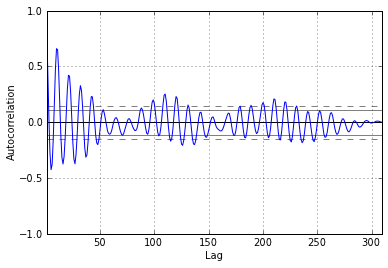

In [8]:
## do some research on the autocorrelation_plot() function in df! what do you find? code up a call to the 
## autocorrelation function on your sunspot data from the previous cell

That the blue line goes beyond the horizontal grey lines indicates that this is a non-stationary time series with correlation structure. For my purposes here, I am not interested in fitting a model to the data. Instead, I just want to learn more about the length of the typical sunspot cycle. For this need it helps to view the time series' autocorrelation function in the _frequency_ domain instead of the temporal domain. So, we create an array of frequencies to evaluate the series over...

In [9]:
import numpy as np
N2 = df.shape[0] / 2
freqs = np.linspace(0, 0.5, num=N2, endpoint=False)[1:] #Nyquist range

...then, using these frequencies, plot the _periodogram_, which is the frequency domain analog of the autocorrelation plot above. Note that the [Lomb-Scargle method](http://en.wikipedia.org/wiki/Least-squares_spectral_analysis) used below assumes that the frequencies are not in a typical unit like Hertz (cycles per second) but rather as [angular frequencies](http://en.wikipedia.org/wiki/Angular_frequency), which is why we need to multiply the values by $2\pi$. (The Lomb-Scargle method is flexible in that the time series need not be uniformly sampled.)

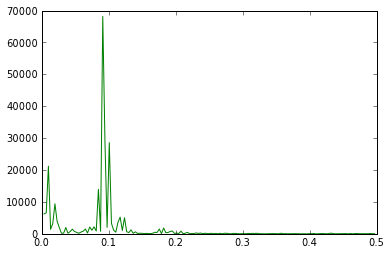

In [10]:
import scipy as sp
periodogram = sp.signal.lombscargle(df['YEAR'], df['SUNACTIVITY'], freqs * 2 * np.pi)
plt.plot(freqs, periodogram, color='green')

We see a big spike in the power of the series at a frequency of just below 0.1. Recall that these are yearly observations, so we can divide this frequency into 1 to get the period of each cycle...

In [11]:
freq_index_at_max_power = np.argmax(periodogram)
print 'Frequency and corresponding time in years at max power: %.2f, %.1f' % (freqs[freq_index_at_max_power], 1 / freqs[freq_index_at_max_power])

Frequency and corresponding time in years at max power: 0.09, 11.0


The major cycle is about 11 years, which is what the literature states. So, we could have skipped this previous step entirely and just assumed the data had an 11 year cycle like the literature said, but it is always good to sanity check what you are working with, and of course, in many settings one does not already know such things, hence the need for exploration.

At this point, after a handful of lines of code and some internet searches we have a basic handle on:

* The data generating process
* Distributional information
* Temporal behavior

Can you think of other ways to display this data? We used the default .plot() function, which gave us a line graph. How would you go about making a scatterplot? A histogram with frequencies? How could you bin your datapoints into buckets? 

##References

[1] _The Elements of Graphing Data_, William S. Cleveland, Hobart Press, Summit, New Jersey, 1994
    ISBN: 0-9634884-1-4     
[2] _IPython: A System for Interactive Scientific Computing_, Fernando Pérez, Brian E. Granger, Computing in Science and Engineering, vol. 9, no. 3, pp. 21-29, May/June 2007, doi:10.1109/MCSE.2007.53. URL: http://ipython.org